# Import libs

In [1]:
#Pytorch modules
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms, models

#Import metcirs
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

from math import ceil

#Import class for images
from PIL import Image

#Plotting
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

#Status bar
from tqdm.notebook import tqdm

from collections import namedtuple

# Define path to images

In [2]:
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Create datasets

In [3]:
class ImageFolder(datasets.ImageFolder):
    """Modified torchvision.datasets.ImageFolder class with additional options:
        Preload images.
        Train / validation split.
        Support for multiple directories.
    
    Args:
        folders (list): Path list.
        loader (callable): A function to load a sample given its path.
        preload_size (tuple): Size of images after loading.
        transform (callable, optional): A function/transform that takes in a sample and returns a transformed version.
        load_transform (callable, optional): A function/transform that takes in a loading sample and returns a transformed version.
        val_transform (callable, optional): A function/transform that takes in a vlalidate sample and returns a transformed version.
        val_indices (iterable, optional): List of indices for validate.
    
    Attributes:
        classes (list): List of the class names sorted alphabetically.
        class_to_idx (dict): Dict with items (class_name, class_index).
        imgs (list): List of (image path, class_index) tuples.
        imgs_tensor (Tensor): Tensor with preload images.
    """
    
    def __init__(self, folders, loader, preload_size, transform = None, load_transform = None, val_transform = None,val_indices = []):
        
        imgs = None
        imgs_tensor = None
        
        self.load_transform = load_transform
        self.val_transform = val_transform
        self.val_indices = val_indices
        
        for root in folders:
            super(ImageFolder, self).__init__(root, transform = transform, loader = loader)
            
            bar = tqdm(range(len(self.imgs)), desc="Loading images")
            
            imgs_tensor_tmp = torch.zeros([len(self.imgs), *preload_size])
            imgs_tmp = self.imgs
            
            for index in range(len(self.imgs)):
                if self.load_transform:
                    imgs_tensor_tmp[index, :, :, :] = self.load_transform(loader(self.imgs[index][0]))
                else:
                    imgs_tensor_tmp[index, :, :, :] = loader(self.imgs[index][0])
                
                bar.update()
            
            if imgs is not None:
                imgs += imgs_tmp
                imgs_tensor = torch.cat((imgs_tensor, imgs_tensor_tmp))
            else:
                imgs = imgs_tmp
                imgs_tensor = imgs_tensor_tmp
            
            bar.close()
            
        self.imgs = imgs
        self.imgs_tensor = imgs_tensor
                
    def __getitem__(self, index):
        """
        Args:
            index (int): Index.

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        if self.val_transform and index in self.val_indices:
            return self.val_transform(self.imgs_tensor[index]),  self.imgs[index][1]
        if self.transform:
            return self.transform(self.imgs_tensor[index]),  self.imgs[index][1]
        return self.imgs_tensor[index],  self.imgs[index][1]
    
    def __len__(self):
        return len(self.imgs)
        

load_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor()])  
        
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                       transforms.RandomRotation(25),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.4823, 0.4823, 0.4823],
                                                            [0.2361, 0.2361, 0.2361])])

val_transforms = transforms.Compose([transforms.Normalize([0.4823, 0.4823, 0.4823],
                                                          [0.2361, 0.2361, 0.2361])])

test_transforms = transforms.Compose([transforms.Normalize([0.4823, 0.4823, 0.4823],
                                                           [0.2361, 0.2361, 0.2361])])

train_dataset = ImageFolder([train_dir, val_dir], loader = Image.open, preload_size = (3, 224, 224),
                            transform=train_transforms,
                            load_transform = load_transforms,
                            val_transform = val_transforms,)

test_dataset = ImageFolder([test_dir], loader = Image.open, preload_size = (3, 224, 224),
                           transform=test_transforms,
                           load_transform = load_transforms)

Loading images:   0%|          | 0/5216 [00:00<?, ?it/s]

Loading images:   0%|          | 0/16 [00:00<?, ?it/s]

Loading images:   0%|          | 0/624 [00:00<?, ?it/s]

# Show train samples

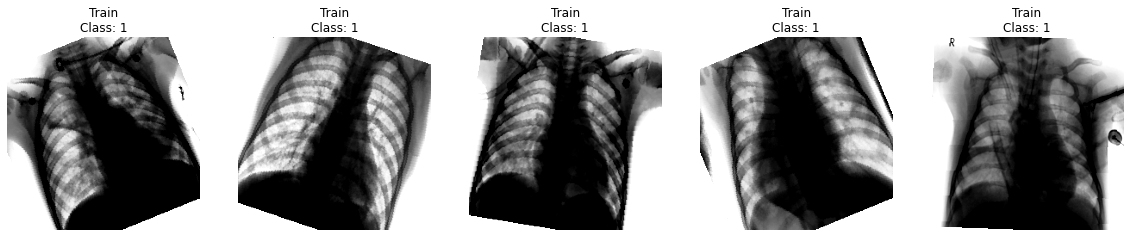

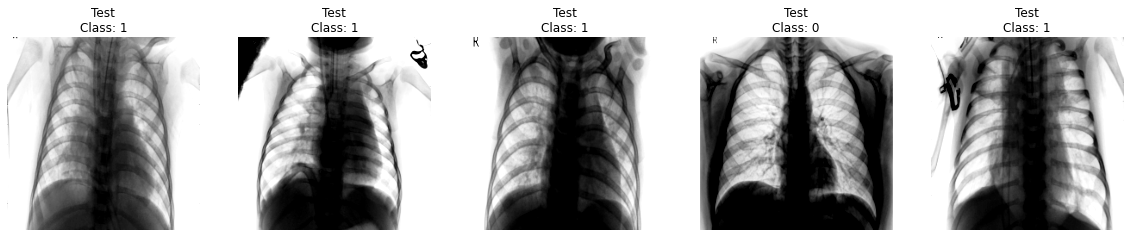

In [4]:
def show_samples(dataset, title, minimum, maximum):
    """Show samples of dataset with label.
    
    Args:
        dataset (ImageFolder): ImageFolder dataset.
        title (str): Title of images.
        minimum (float): Minimum value for colormap.
        maximum (float): Maximum value for colormap.
    """
    
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize = (20, 11))
    indices = torch.randperm(len(dataset))
    
    for i in range(5):
        im = ax[i].imshow(dataset[indices[i]][0][0], cmap=plt.get_cmap("Greys"))
        im.set_clim(minimum, maximum)
        
        ax[i].axis('off')
        ax[i].set_title(title + '\nClass: ' + str(dataset[indices[i]][1]))
    
    plt.show()

minimum = (train_dataset.imgs_tensor.min() - 0.4823) / (0.2361 ** 0.5)
maximum = (train_dataset.imgs_tensor.max() - 0.4823) / (0.2361 ** 0.5)

show_samples(train_dataset, 'Train', minimum, maximum)
show_samples(test_dataset, 'Test', minimum, maximum)

# Show imbalance of datasets

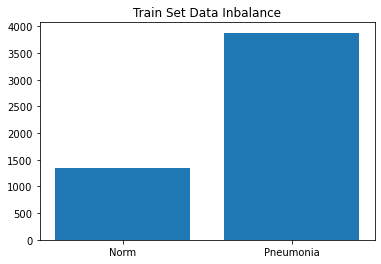

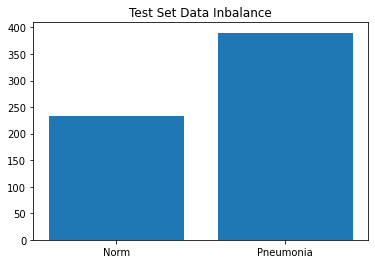

In [5]:
def show_imbalance(dataset, title):
    """Show samples of dataset with label.
    
    Args:
        dataset (ImageFolder): ImageFolder dataset.
        title (str): Title of figure.
    """
    
    norm = 0
    pn = 0
    
    for i in dataset.imgs:
        if i[1]:
            pn += 1
        else:
            norm += 1
    
    ax = plt.bar([0, 1], [norm, pn])
    
    plt.title(title)
    plt.xticks([0, 1], ['Norm', 'Pneumonia'])
    plt.show()

show_imbalance(train_dataset, 'Train Set Data Inbalance')
show_imbalance(test_dataset, 'Test Set Data Inbalance')

# Create callback for train process

In [6]:
class EarlyStop():
    """Callback for early stop train process.
    
    Args:
        monitor (str): value for monitoring.
        patience (int): Number of epochs with no improvement after which training will be stopped.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, patience, mode):
        self.monitor = monitor
        self.patience = patience
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
            
    def start(self, history, model):
        """Start and init callback.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model.
        """
        
        self.history = history
        self.model = model
        
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps - self.best_step > self.patience:
            return 'Early stop with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), True
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()


class SaveBest():
    """Callback for save model if there is an improvement.
    
    Args:
        monitor (str): value for monitoring.
        model_path (str): Path for saving model.
        mode (str): One of {"min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing.
            In "max" mode it will stop when the quantity monitored has stopped increasing.
    
    Attributes:
        history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
        steps (int): Number of passed epoches. 
        best_step (int): Number of best epoch. 
        best_monitor (float): Best of monitoring value.
        model (Model): Training model
    """
    
    def __init__(self, monitor, model_path, mode):
        self.monitor = monitor
        self.model_path = model_path
        self.mode = mode
        self.history = None
        self.steps = -1
        self.best_step = -1
        if self.mode == 'max':
            self.best_monitor = 0
        elif self.mode == 'min':
            self.best_monitor = 1e99999
    
    def start(self, history, model):
        """Start and init callback. Save first version of model.
        
        Args:
            history (dict): Dict of lists with train history. Key "monitor" contains list of monitoring values. 
            model (Model): Training model
        """
        
        self.history = history
        self.model = model
        
        torch.save(self.model.state_dict(), self.model_path)
    
    def step(self):
        """Make a step of callback.
        
        Returns:
            tuple: (event, stop):
                event (str): Decription of event. If event not did not happen then event = ''.
                stop (bool): Flag of stopping train process.
        """
        
        self.steps += 1
        
        if self.mode == 'max':
            if self.history[self.monitor][-1] > self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        elif self.mode == 'min':
            if self.history[self.monitor][-1] < self.best_monitor:
                self.best_monitor = self.history[self.monitor][-1]
                self.best_step = self.steps
        
        if self.steps == self.best_step:
            torch.save(self.model.state_dict(), self.model_path)
            return 'Save model with {}: {:.4f}'.format(self.monitor, self.history[self.monitor][self.best_step]), False
        return None, False
    
    def stop(self):
        """Delete model from callback."""
        
        self.model = None
        torch.cuda.empty_cache()

# Functions for work with model

In [7]:
def predict(loader, model):
    """Make model predictions on loader data.
    
    Args:
        loader (DataLoader): DataLoader with data for predictions.
        model (Model): Current model.
    
    Returns:
        tuple: (act_classes, pred_classes):
            act_classes (list): List of actual classes.
            pred_classes (list): List of predicted classes.
    """
    
    model.eval()
    
    act_classes = None
    pred_classes = None
    
    sm = torch.nn.Softmax(dim=1)
    
    for images, labels in iter(loader):
        if torch.cuda.is_available():
            images, labels = images.to('cuda'), labels.to('cuda')

        output = sm(model.forward(images)).argmax(1)
        
        if act_classes is None:
            act_classes = labels.cpu()
            pred_classes = output.cpu()
        else:
            act_classes = torch.cat((act_classes, labels.cpu()))
            pred_classes = torch.cat((pred_classes, output.cpu()))
    
    model = None
    images = None
    labels = None
    output = None
    sm = None
    
    torch.cuda.empty_cache()
    
    return list(act_classes), list(pred_classes)


def predict_image(image, model):
    """Make model prediction on image.
    
    Args:
        image (Tensor): Tensor with image.
        model (Model): Current model.
    
    Returns:
        output (int): indiex of predicted class.
    """
    
    model.eval()
    
    sm = torch.nn.Softmax(dim=1)
    
    image = image.unsqueeze(0)
    
    if torch.cuda.is_available():
        image = image.to('cuda')
    
    output = sm(model.forward(image)).argmax(1).item()
    
    model = None
    images = None
    sm = None
    
    torch.cuda.empty_cache()
    
    return output


def evaluate_model(model, loader, criterion, metric_fn):
    """Make model evaluation on loader data.
    
    Args:
        model (Model): Current model.
        loader (DataLoader): DataLoader with data for predictions.
        criterion (callable): Function for loss calculation.
        metric_fn (callable): Function for metric calculation.
    
    Returns:
        tuple: (loss, metric):
            loss (float): Value of loss.
            metric (float): Value of metric.
    """
    
    model.eval()
    
    labels_all = None
    outputs = None
    
    sm = torch.nn.Softmax(dim=1)
    
    for images, labels in iter(loader):
        if torch.cuda.is_available():
            images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        
        if outputs is not None:
            outputs = torch.cat((outputs, output.cpu()), 0)
            labels_all = torch.cat((labels_all, labels.cpu()), 0)
        else:
            outputs = output.cpu()
            labels_all = labels.cpu()
    
    model = None
    images = None
    labels = None
    output = None  
    sm = None
    
    torch.cuda.empty_cache()
    
    return criterion(outputs, labels_all), metric_fn(labels_all, outputs.argmax(1))


def train_classifier(model, train_loader, val_loader, optimizer, criterion, metric_fn, metric_name,
                     epochs = 20, print_every = 10, callbacks = None):
    """Make model prediction on image.
    
    Args:
        model (Model): Model for training.
        train_loader (DataLoader): loader with train data.
        val_loader (DataLoader): loader with validation data.
        optimizer (Optimizer): Optimizer. 
        criterion (callable): Function for loss calculation.
        metric_fn (callable): Function for metric calculation.
        metric_name (str): Name of metric.
        epochs (int): Number of epoches.
        print_every (int): Number of iteration for update statusbar.
        callbacks (list): List of callbacks
    
    Returns:
        history (dict): Dict of lists with train history.
    """
    
    history = {'Train loss':[], 'Train {}'.format(metric_name):[], 'Val loss':[], 'Val {}'.format(metric_name):[]}
    
    if callbacks:
        for i in callbacks:
            i.start(history, model)
    
    for e in range(epochs):
        model.train()

        running_loss = 0
        running_accuracy = 0
        
        sm = torch.nn.Softmax(dim = 1)
        
        stop = False
        
        steps = 0
        
        train_print = ''
        bar = tqdm(range(len(train_loader)), desc="Epoch {}/{}".format(e+1, epochs), postfix=train_print)
        
        for images, labels in iter(train_loader):
            steps += 1
        
            if torch.cuda.is_available():
                images, labels = images.to('cuda'), labels.to('cuda')
    
            optimizer.zero_grad()
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                running_loss += loss.item()

                probabilities = sm(output).argmax(dim=1).cpu()
                
                running_accuracy += metric_fn(labels.cpu(), probabilities)
            
            if steps % print_every == 0:
                train_print = "Train loss: {:.4f}, Train {}: {:.4f}".format(running_loss / steps, metric_name, running_accuracy / steps)
                bar.postfix = train_print
                model.train()
            
            if steps != len(train_loader):
                bar.update()

        with torch.no_grad():
            val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, metric_fn)
        
        train_print = "Train loss: {:.4f}, Train {}: {:.4f}, Val loss: {:.4f}, Val {}: {:.4f}".format(
             running_loss / steps,
             metric_name,
             running_accuracy / steps,
             val_loss,
             metric_name,
             val_accuracy)
        
        history['Train loss'].append(running_loss / steps)
        history['Train {}'.format(metric_name)].append(running_accuracy / steps)
        history['Val loss'].append(val_loss.item())
        history['Val {}'.format(metric_name)].append(val_accuracy)
        
        if callbacks:
            for i in callbacks:
                state_text, state = i.step()
                if state_text:
                    train_print += ', ' + state_text
                if state:
                    stop = True
        
        bar.postfix = train_print
        bar.update()
        bar.close()
        
        if stop:
            if callbacks:
                for i in callbacks:
                    i.stop()
            model = None
            images = None
            labels = None
            output = None
            loss = None
            sm = None
            
            torch.cuda.empty_cache()
            
            break
                
        images = None
        labels = None
        output = None
        loss = None
        sm = None
        
        torch.cuda.empty_cache()

    if callbacks:
        for i in callbacks:
            i.stop()
    
    model = None
    
    torch.cuda.empty_cache()
    
    return history

# Train model

In [8]:
Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'batch_size'])
RunResult = namedtuple("RunResult", ['model_path', 'history', 'final_val_F1_score'])

learning_rates = [1e-3, 1e-2]
batch_sizes = [16, 32]

epoch_num = 10
val_split = .2

indices = torch.randperm(len(train_dataset))

train_sampler = SubsetRandomSampler(indices[int(len(train_dataset) * 0.2):])
val_sampler = SubsetRandomSampler(indices[:int(len(train_dataset) * 0.2)])

train_dataset.val_indices = indices[:int(len(train_dataset) * 0.2)]

val_loader = DataLoader(train_dataset, batch_size = 16, sampler = val_sampler)
test_loader = DataLoader(test_dataset, batch_size = 16)

criterion = nn.CrossEntropyLoss()

run_record = {}

for lr in learning_rates:
    for bs in batch_sizes:
        
        print(str(Hyperparams(lr, bs)))
        
        train_loader = DataLoader(train_dataset, batch_size = bs, sampler = train_sampler)
        
        model_path = './model ' + str(Hyperparams(lr, bs)) + '.pth'
        
        callbacks = [EarlyStop('Val F1 score', 2, 'max'), SaveBest('Val F1 score', model_path, 'max')]
        
        model = models.alexnet(True)
        model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2, bias=True)
        if torch.cuda.is_available():
            model = model.to('cuda')
            
        optimizer = optim.Adam(model.classifier[6].parameters(), lr = lr)

        history = train_classifier(model, train_loader, val_loader, optimizer, criterion,
                                   metric_fn = f1_score, metric_name = 'F1 score', epochs = epoch_num,callbacks = callbacks)
        
        run_record[Hyperparams(lr, bs)] = RunResult(model_path, history, callbacks[1].best_monitor)
        
        model = None
        optimizer = None
        
        torch.cuda.empty_cache()

best_val_F1_score = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_F1_score is None or best_val_F1_score < run_result.final_val_F1_score:
        best_val_F1_score = run_result.final_val_F1_score
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best val F1score: %4.4f, best hyperparams: %s" % (best_val_F1_score, best_hyperparams))

model = models.alexnet(True)
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2, bias=True)
model.load_state_dict(torch.load(best_run.model_path))
if torch.cuda.is_available():
    model = model.to('cuda')

Hyperparams(learning_rate=0.001, batch_size=16)


Epoch 1/10:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/262 [00:00<?, ?it/s]

Hyperparams(learning_rate=0.001, batch_size=32)


Epoch 1/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/131 [00:00<?, ?it/s]

Hyperparams(learning_rate=0.01, batch_size=16)


Epoch 1/10:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/262 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/262 [00:00<?, ?it/s]

Hyperparams(learning_rate=0.01, batch_size=32)


Epoch 1/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/131 [00:00<?, ?it/s]

Best val F1score: 0.9672, best hyperparams: Hyperparams(learning_rate=0.001, batch_size=32)


# Print model

In [9]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Evaluate model

In [10]:
with torch.no_grad():
    loss, accuracy = evaluate_model(model, train_loader, criterion, f1_score)
    print("Train loss: {:.4f}, Train F1 score: {:.4f}".format(loss, accuracy))  
    loss, accuracy = evaluate_model(model, val_loader, criterion, f1_score)
    print("Val loss: {:.4f}, Val F1 score: {:.4f}".format(loss, accuracy))  
    loss, accuracy = evaluate_model(model, test_loader, criterion, f1_score)  
    print("Test loss: {:.4f}, Test F1 score: {:.4f}".format(loss, accuracy))  

Train loss: 0.1286, Train F1 score: 0.9667
Val loss: 0.1435, Val F1 score: 0.9672
Test loss: 0.5638, Test F1 score: 0.8664


In [11]:
with torch.no_grad():
    loss, accuracy = evaluate_model(model, train_loader, criterion, recall_score)
    print("Train loss: {:.4f}, Train recall: {:.4f}".format(loss, accuracy))  
    loss, accuracy = evaluate_model(model, val_loader, criterion, recall_score)
    print("Val loss: {:.4f}, Val recall: {:.4f}".format(loss, accuracy))
    loss, accuracy = evaluate_model(model, test_loader, criterion, recall_score)  
    print("Test loss: {:.4f}, Test recall: {:.4f}".format(loss, accuracy))  

Train loss: 0.1222, Train recall: 0.9655
Val loss: 0.1435, Val recall: 0.9746
Test loss: 0.5638, Test recall: 0.9897


In [12]:
with torch.no_grad():
    loss, accuracy = evaluate_model(model, train_loader, criterion, precision_score)
    print("Train loss: {:.4f}, Train precision: {:.4f}".format(loss, accuracy))  
    loss, accuracy = evaluate_model(model, val_loader, criterion, precision_score)
    print("Val loss: {:.4f}, Val precision: {:.4f}".format(loss, accuracy))  
    loss, accuracy = evaluate_model(model, test_loader, criterion, precision_score)  
    print("Test loss: {:.4f}, Test precision: {:.4f}".format(loss, accuracy))  

Train loss: 0.1271, Train precision: 0.9698
Val loss: 0.1435, Val precision: 0.9599
Test loss: 0.5638, Test precision: 0.7705


# Plot train history

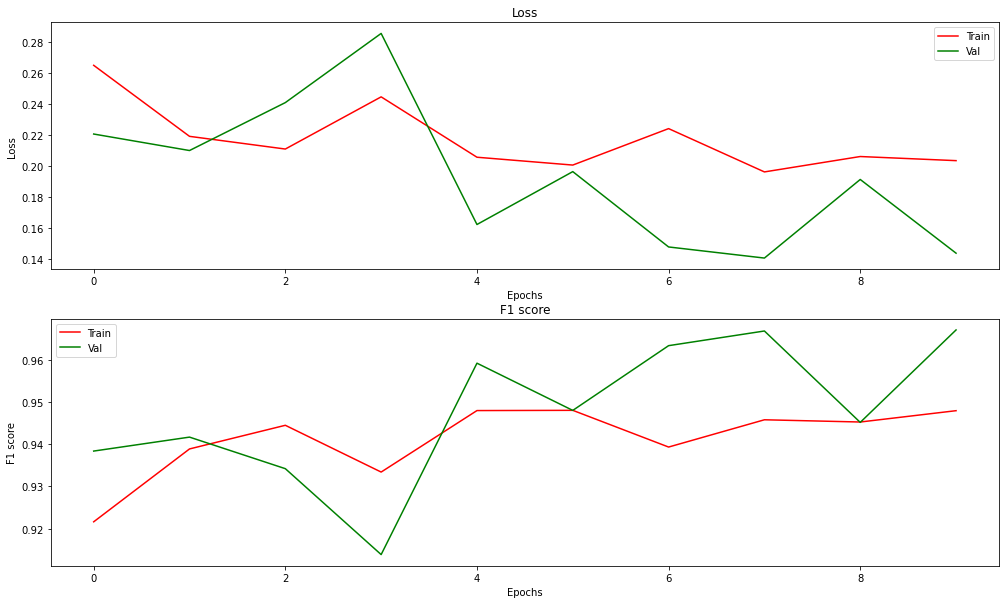

In [13]:
def plot_train_history(history):
    """Plot train history.
    
    Args:
        history (dict): Dict of lists with train history..
    """
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize = (17, 10))
    
    ax[0].plot(history['Train loss'], c = 'r')
    ax[0].plot(history['Val loss'], c = 'g')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(['Train', 'Val'])
    
    ax[1].plot(history['Train F1 score'], c = 'r')
    ax[1].plot(history['Val F1 score'], c = 'g')
    ax[1].set_title('F1 score')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('F1 score')
    ax[1].legend(['Train', 'Val'])
    
    plt.show()

plot_train_history(best_run.history)

# Plot confusion matrix

<Figure size 432x288 with 0 Axes>

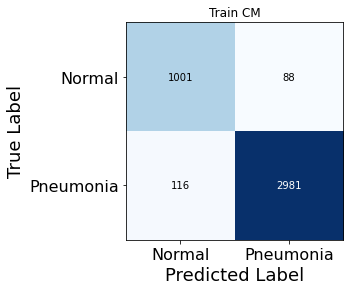

<Figure size 432x288 with 0 Axes>

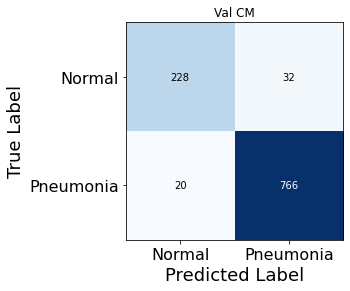

<Figure size 432x288 with 0 Axes>

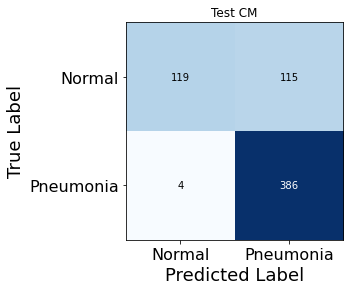

In [14]:
def plot_cm(model, loader, title):
    """Show confusion matrix for predictions of model on loader data.
    
    Args:
        model (Model): Model for predictions.
        title (str): Title of CM.
    """
    
    plt.figure()
    
    with torch.no_grad():
        labels, preds = predict(loader, model)
    
    cm  = confusion_matrix(labels, preds)
    
    plot_confusion_matrix(cm,figsize=(6,4),cmap=plt.cm.Blues)
    plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.xlabel('Predicted Label',fontsize=18)
    plt.ylabel('True Label',fontsize=18)
    plt.title(title + " CM")
    plt.show()

plot_cm(model, train_loader, 'Train')
plot_cm(model, val_loader, 'Val')
plot_cm(model, test_loader, 'Test')

# Show samples with predictions

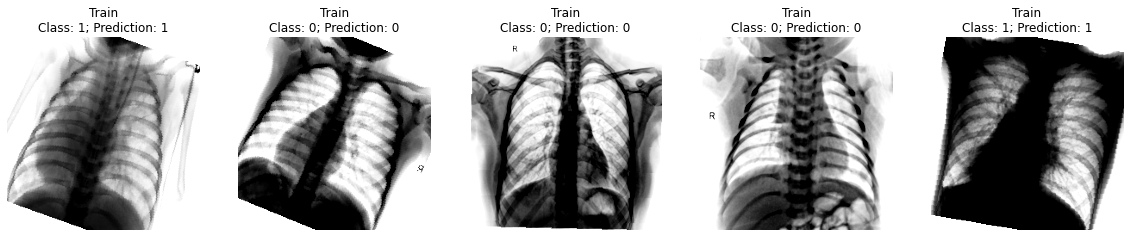

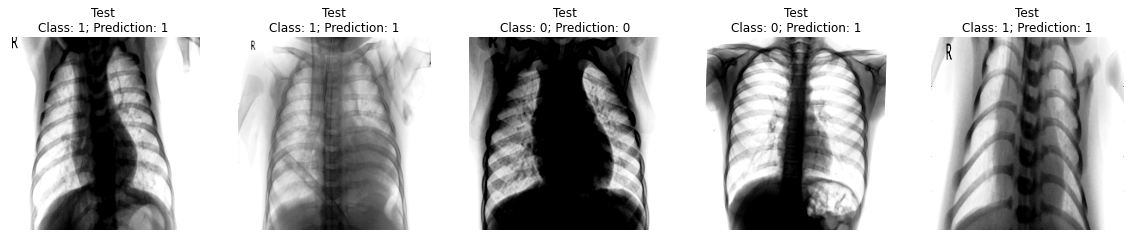

In [15]:
def show_predictions(model, dataset, title, minimum, maximum):
    """Show samples of dataset with label and prediction.
    
    Args:
        model (Model): Model for predictions.
        dataset (ImageFolder): ImageFolder dataset.
        title (str): Title of images.
        minimum (float): Minimum value for colormap.
        maximum (float): Maximum value for colormap.
    """
    
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize = (20, 11))
    
    indices = torch.randperm(len(dataset))
    
    for i in range(5):
        im = ax[i].imshow(dataset[indices[i]][0][0], cmap=plt.get_cmap("Greys"))
        im.set_clim(minimum, maximum)
        
        with torch.no_grad():
            pred = predict_image(dataset[indices[i]][0], model)
            
        ax[i].axis('off')
        ax[i].set_title(title + '\nClass: ' + str(dataset[indices[i]][1]) + '; Prediction: ' + str(pred))
    
    plt.show()

show_predictions(model, train_dataset, 'Train', minimum, maximum)
show_predictions(model, test_dataset, 'Test', minimum, maximum)

# Visualization of hidden convolution layers

Conv2d(3, 64)
Class: 1; Prediction: 1


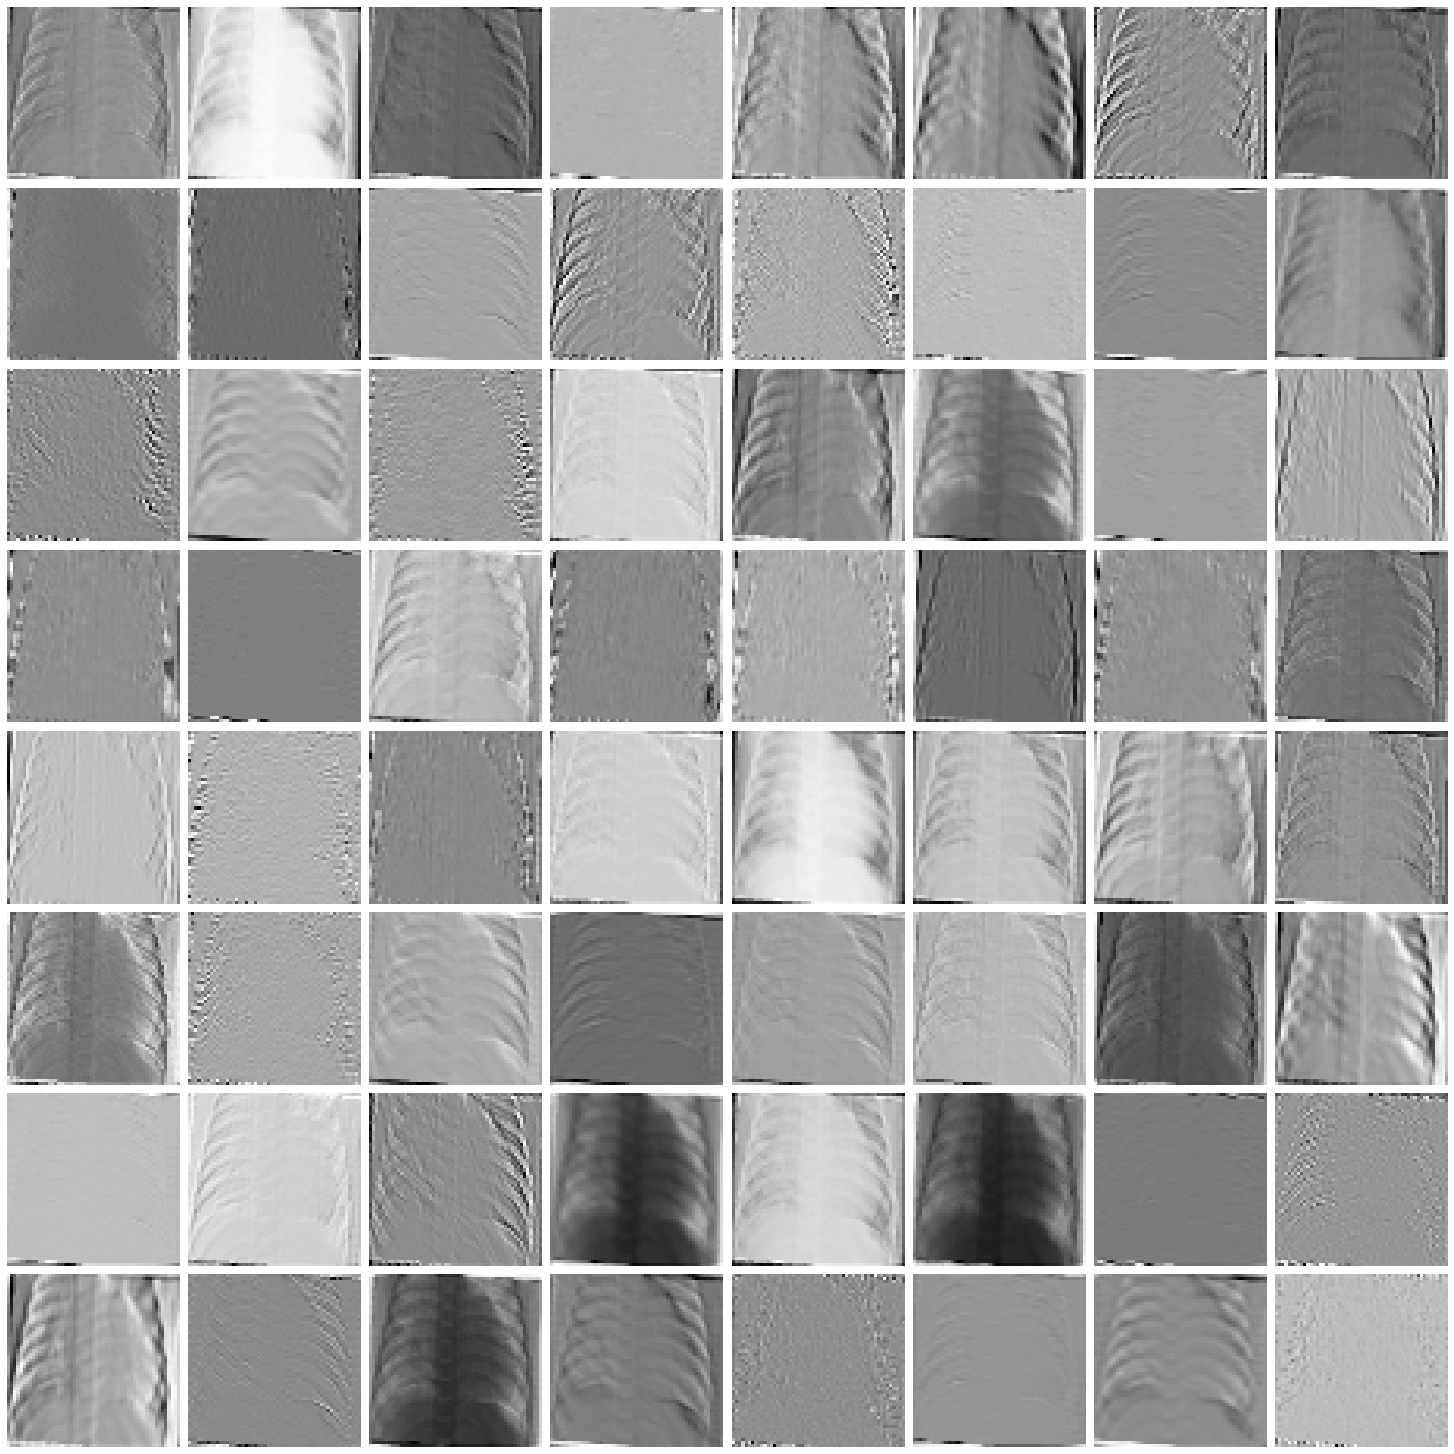

In [16]:
def hit_map(model, x, part, num):
    """Gives hit map of hidden layer.
    
    Args:
        model (Model): Model for prediction.
        x (Tensor): Tensor with image.
        part (str): Model part name.
        num (int): Model part layer number.
        
    Return:
        x (Tensor): Tensor with hitmap.
    """
    
    if len(x.size()) < 4:
        x = x.unsqueeze(0)
    
    model.eval()
    
    if torch.cuda.is_available():
        x = x.to('cuda')
    if part == 'features':
        for i in range(num + 1):
            x = model.features[i](x)
    elif part == 'avgpool':
        x = model.features(x)
        x = model.avgpool(x)
    elif part == 'classifer':
        x = model.features(x)
        x = model.avgpool(x)
        for i in range(num + 1):
            x = model.classifer[i](x)
    
    return x
    

def show_hit_map(model, image, label, title, part, num):
    """Show hit map of hidden layer.
    
    Args:
        model (Model): Model for prediction.
        image (Tensor): Tensor with image.
        label (int): Index of class.
        title (str): Title of figure.
        part (str): Model part name.
        num (int): Model part layer number.
    """
    
    with torch.no_grad():
        images = hit_map(model, image, part, num)
        pred = predict_image(image, model)
    
    x = int(ceil(len(images[0]) ** 0.5))
    y = int(ceil(len(images[0]) ** 0.5))
    
    print(title + '\nClass: ' + str(label) + '; Prediction: ' + str(pred))
    
    fig, ax = plt.subplots(nrows=x, ncols=y, figsize = (20, 20))
    plt.subplots_adjust(wspace=0.05, hspace=0.05, left=0, right=1, bottom=0, top=1)
    
    count = 0
    for i in range(x):
        for j in range(y):
            if count < len(images[0]):
                ax[i, j].imshow(images.cpu()[0, count], cmap=plt.get_cmap("Greys"))
            ax[i, j].axis('off')
            count += 1
    
    images = None
    pred = None
    
    torch.cuda.empty_cache()

    plt.show()

indices = torch.randperm(len(train_dataset))
show_hit_map(model, *train_dataset[indices[0]], 'Conv2d(3, 64)', 'features', 0)